# Flight Trajectory Visualization

This notebook visualizes flight trajectories from CSV files using Cartopy for geographic mapping.
It plots waypoint nodes and flight routes on a map for better trajectory analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import networkx as nx
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## Configuration

Set up file paths and parameters for visualization.

In [3]:
# File paths
CSV_DIR = Path('../output/city_pairs/representatives_filtered')
GRAPH_FILE = Path('D:/project-akrav/data/graphs/ats_fra_nodes_only.gml')

# Visualization parameters
FIGURE_SIZE = (15, 10)
NODE_SIZE = 8
TRAJECTORY_WIDTH = 1.5
NODE_COLOR = 'red'
TRAJECTORY_COLOR = 'blue'
TRAJECTORY_ALPHA = 0.7

## Load Waypoint Graph

Load the waypoint graph containing nodes with latitude and longitude coordinates.

In [4]:
def load_waypoint_graph(graph_file):
    """
    Load waypoint graph from GML file and extract node coordinates.
    
    Returns:
        dict: Dictionary mapping waypoint labels to (lat, lon) coordinates
    """
    try:
        G = nx.read_gml(graph_file)
        waypoints = {}
        
        for node_id, data in G.nodes(data=True):
            waypoints[node_id] = (float(data['lat']), float(data['lon']))
        
        print(f"Loaded {len(waypoints)} waypoints from graph")
        return waypoints
    
    except Exception as e:
        print(f"Error loading graph: {e}")
        return {}

# Load waypoint coordinates
waypoints = load_waypoint_graph(GRAPH_FILE)
print(f"Sample waypoints: {list(waypoints.items())[:5]}")

Loaded 33763 waypoints from graph
Sample waypoints: [('RIDLA', (45.749722, 37.365)), ('UGZIR', (45.89, 37.583333)), ('ENILO', (46.174722, 38.031667)), ('SARZI', (46.596667, 38.715833)), ('AMEPU', (47.197778, 39.825))]


## Load and Process CSV Data

Functions to load trajectory data from CSV files and extract waypoint sequences.

In [5]:
def load_csv_data(csv_file):
    """
    Load trajectory data from CSV file.
    
    Returns:
        DataFrame: Trajectory data with origin, destination, and route columns
    """
    try:
        df = pd.read_csv(csv_file)
        print(f"Loaded {len(df)} trajectories from {csv_file.name}")
        return df
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return pd.DataFrame()

def parse_route(route_string):
    """
    Parse route string to extract waypoint sequence.
    
    Args:
        route_string: Space-separated waypoint names
    
    Returns:
        list: List of waypoint names
    """
    if pd.isna(route_string):
        return []
    
    # Split route and clean waypoint names (remove suffixes like _30, _66)
    waypoint_names = []
    for wp in str(route_string).split():
        # Remove numeric suffixes (e.g., AKIKA_30 -> AKIKA)
        clean_wp = wp.split('_')[0]
        waypoint_names.append(clean_wp)
    
    return waypoint_names

def get_trajectory_coordinates(waypoint_sequence, waypoint_dict):
    """
    Convert waypoint sequence to coordinate sequence.
    
    Args:
        waypoint_sequence: List of waypoint names
        waypoint_dict: Dictionary mapping waypoint names to coordinates
    
    Returns:
        tuple: (latitudes, longitudes) for valid waypoints
    """
    lats, lons = [], []
    
    for wp in waypoint_sequence:
        if wp in waypoint_dict:
            lat, lon = waypoint_dict[wp]
            lats.append(lat)
            lons.append(lon)
    
    return lats, lons

## Visualization Functions

Functions to create map visualizations with trajectories and waypoints.

In [6]:
def create_map(extent=None):
    """
    Create a cartopy map with geographic features.
    
    Args:
        extent: [lon_min, lon_max, lat_min, lat_max] for map bounds
    
    Returns:
        tuple: (figure, axis) objects
    """
    fig = plt.figure(figsize=FIGURE_SIZE)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.3)
    ax.add_feature(cfeature.OCEAN, alpha=0.3)
    
    # Set extent if provided
    if extent:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
    return fig, ax

def plot_trajectories(ax, df, waypoints, max_trajectories=50, show_waypoints=True, show_labels=True):
    """
    Plot trajectories on the map.
    
    Args:
        ax: Cartopy axis object
        df: DataFrame with trajectory data
        waypoints: Dictionary of waypoint coordinates
        max_trajectories: Maximum number of trajectories to plot
        show_waypoints: Whether to show waypoint nodes
        show_labels: Whether to show waypoint labels
    """
    plotted_trajectories = 0
    all_waypoint_coords = set()
    waypoint_labels = {}  # Store waypoint names for labeling
    
    for idx, row in df.iterrows():
        if plotted_trajectories >= max_trajectories:
            break
            
        waypoint_sequence = parse_route(row['route'])
        lats, lons = get_trajectory_coordinates(waypoint_sequence, waypoints)
        
        if len(lats) >= 2:  # Need at least 2 points for a trajectory
            # Plot trajectory line
            ax.plot(lons, lats, 
                   color=TRAJECTORY_COLOR, 
                   linewidth=TRAJECTORY_WIDTH, 
                   alpha=TRAJECTORY_ALPHA,
                   transform=ccrs.PlateCarree())
            
            # Collect waypoint coordinates and names for later plotting
            for i, (lat, lon) in enumerate(zip(lats, lons)):
                coord = (lat, lon)
                all_waypoint_coords.add(coord)
                # Store the waypoint name for this coordinate
                if i < len(waypoint_sequence):
                    waypoint_labels[coord] = waypoint_sequence[i]
            
            plotted_trajectories += 1
    
    # Plot waypoint nodes and labels
    if show_waypoints and all_waypoint_coords:
        waypoint_lats, waypoint_lons = zip(*all_waypoint_coords)
        ax.scatter(waypoint_lons, waypoint_lats, 
                  c=NODE_COLOR, 
                  s=NODE_SIZE, 
                  alpha=0.8,
                  transform=ccrs.PlateCarree(),
                  zorder=5)
        
        # Add waypoint labels if requested
        if show_labels:
            # Calculate appropriate font size based on number of waypoints
            n_waypoints = len(all_waypoint_coords)
            if n_waypoints <= 20:
                fontsize = 8
            elif n_waypoints <= 50:
                fontsize = 6
            elif n_waypoints <= 100:
                fontsize = 5
            else:
                fontsize = 4
            
            # Add labels for each waypoint
            for coord, label in waypoint_labels.items():
                lat, lon = coord
                ax.text(lon, lat, label, 
                       fontsize=fontsize, 
                       ha='center', 
                       va='bottom',
                       transform=ccrs.PlateCarree(),
                       bbox=dict(boxstyle='round,pad=0.2', 
                               facecolor='white', 
                               alpha=0.7,
                               edgecolor='none'),
                       zorder=6)
    
    print(f"Plotted {plotted_trajectories} trajectories with {len(all_waypoint_coords)} unique waypoints")
    return plotted_trajectories, len(all_waypoint_coords)

def get_data_extent(df, waypoints, padding=2.0):
    """
    Calculate map extent based on trajectory data.
    
    Args:
        df: DataFrame with trajectory data
        waypoints: Dictionary of waypoint coordinates
        padding: Degrees to add as padding around data
    
    Returns:
        list: [lon_min, lon_max, lat_min, lat_max]
    """
    all_lats, all_lons = [], []
    
    for _, row in df.iterrows():
        waypoint_sequence = parse_route(row['route'])
        lats, lons = get_trajectory_coordinates(waypoint_sequence, waypoints)
        all_lats.extend(lats)
        all_lons.extend(lons)
    
    if not all_lats:
        return None
    
    lat_min, lat_max = min(all_lats), max(all_lats)
    lon_min, lon_max = min(all_lons), max(all_lons)
    
    return [lon_min - padding, lon_max + padding, 
            lat_min - padding, lat_max + padding]

## Main Visualization Function

Complete function to visualize trajectories from a CSV file.

In [7]:
def visualize_trajectories(origin_airport, destination_airport, max_trajectories=50, show_waypoints=True, show_labels=True, auto_extent=True):
    """
    Complete visualization of trajectories between origin and destination airports.
    
    Args:
        origin_airport: Origin airport code (e.g., 'LFPG')
        destination_airport: Destination airport code (e.g., 'LFBO')
        max_trajectories: Maximum number of trajectories to plot
        show_waypoints: Whether to show waypoint nodes
        show_labels: Whether to show waypoint labels
        auto_extent: Whether to automatically set map extent based on data
    """
    # Extract first 2 characters from each airport code
    origin_prefix = origin_airport[:2]
    dest_prefix = destination_airport[:2]
    
    # Construct CSV filename
    csv_filename = f"{origin_prefix}{dest_prefix}_representatives.csv"
    csv_path = CSV_DIR / csv_filename
    
    print(f"Looking for trajectories from {origin_airport} to {destination_airport}")
    print(f"Using CSV file: {csv_filename}")
    
    if not csv_path.exists():
        print(f"CSV file not found: {csv_path}")
        print(f"Make sure the file {csv_filename} exists in {CSV_DIR}")
        return
    
    df = load_csv_data(csv_path)
    if df.empty:
        print("No data loaded from CSV")
        return
    
    # Filter trajectories that match the exact origin and destination
    filtered_df = df[(df['origin'] == origin_airport) & (df['destination'] == destination_airport)]
    if filtered_df.empty:
        print(f"No trajectories found for {origin_airport} → {destination_airport}")
        print(f"Available routes in {csv_filename}:")
        unique_routes = df.groupby(['origin', 'destination']).size().reset_index(name='count')
        for _, row in unique_routes.head(10).iterrows():
            print(f"  {row['origin']} → {row['destination']} ({row['count']} trajectories)")
        return
    
    print(f"Found {len(filtered_df)} trajectories for {origin_airport} → {destination_airport}")
    
    # Calculate map extent if auto_extent is True
    extent = None
    if auto_extent:
        extent = get_data_extent(filtered_df, waypoints)
    
    # Create map
    fig, ax = create_map(extent)
    
    # Plot trajectories
    n_trajectories, n_waypoints = plot_trajectories(ax, filtered_df, waypoints, max_trajectories, show_waypoints, show_labels)
    
    # Add title and labels
    plt.title(f'Flight Trajectories: {origin_airport} → {destination_airport}\\n'
              f'Region: {origin_prefix} → {dest_prefix} ({n_trajectories} trajectories, {n_waypoints} waypoints)', 
              fontsize=14, pad=20)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color=TRAJECTORY_COLOR, lw=TRAJECTORY_WIDTH, label='Flight Trajectories')]
    if show_waypoints:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=NODE_COLOR, markersize=6, label='Waypoints'))
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\\nVisualization Summary:")
    print(f"- Origin: {origin_airport} (region: {origin_prefix})")
    print(f"- Destination: {destination_airport} (region: {dest_prefix})")
    print(f"- CSV file: {csv_filename}")
    print(f"- Trajectories for this route: {len(filtered_df)}")
    print(f"- Trajectories plotted: {n_trajectories}")
    print(f"- Unique waypoints: {n_waypoints}")
    print(f"- Waypoint labels: {'Shown' if show_labels else 'Hidden'}")
    if extent:
        print(f"- Map extent: {extent}")

def visualize_by_csv_filename(csv_filename, max_trajectories=50, show_waypoints=True, show_labels=True, auto_extent=True):
    """
    Visualize trajectories directly from CSV filename (legacy function).
    
    Args:
        csv_filename: Name of CSV file (e.g., 'LFLF_representatives.csv')
        max_trajectories: Maximum number of trajectories to plot
        show_waypoints: Whether to show waypoint nodes
        show_labels: Whether to show waypoint labels
        auto_extent: Whether to automatically set map extent based on data
    """
    # Load CSV data
    csv_path = CSV_DIR / csv_filename
    if not csv_path.exists():
        print(f"CSV file not found: {csv_path}")
        return
    
    df = load_csv_data(csv_path)
    if df.empty:
        print("No data loaded from CSV")
        return
    
    # Extract origin and destination from filename
    origin_dest = csv_filename.replace('_representatives.csv', '')
    
    # Calculate map extent if auto_extent is True
    extent = None
    if auto_extent:
        extent = get_data_extent(df, waypoints)
    
    # Create map
    fig, ax = create_map(extent)
    
    # Plot trajectories
    n_trajectories, n_waypoints = plot_trajectories(ax, df, waypoints, max_trajectories, show_waypoints, show_labels)
    
    # Add title and labels
    plt.title(f'Flight Trajectories: {origin_dest}\\n'
              f'{n_trajectories} trajectories, {n_waypoints} waypoints', 
              fontsize=14, pad=20)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color=TRAJECTORY_COLOR, lw=TRAJECTORY_WIDTH, label='Flight Trajectories')]
    if show_waypoints:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=NODE_COLOR, markersize=6, label='Waypoints'))
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\\nVisualization Summary:")
    print(f"- CSV file: {csv_filename}")
    print(f"- Total trajectories in file: {len(df)}")
    print(f"- Trajectories plotted: {n_trajectories}")
    print(f"- Unique waypoints: {n_waypoints}")
    print(f"- Waypoint labels: {'Shown' if show_labels else 'Hidden'}")
    if extent:
        print(f"- Map extent: {extent}")

## Example Usage

Visualize trajectories from a specific CSV file.

Looking for trajectories from LEMD to EGLL
Using CSV file: LEEG_representatives.csv
Loaded 1951 trajectories from LEEG_representatives.csv
Found 3 trajectories for LEMD → EGLL
Plotted 3 trajectories with 22 unique waypoints


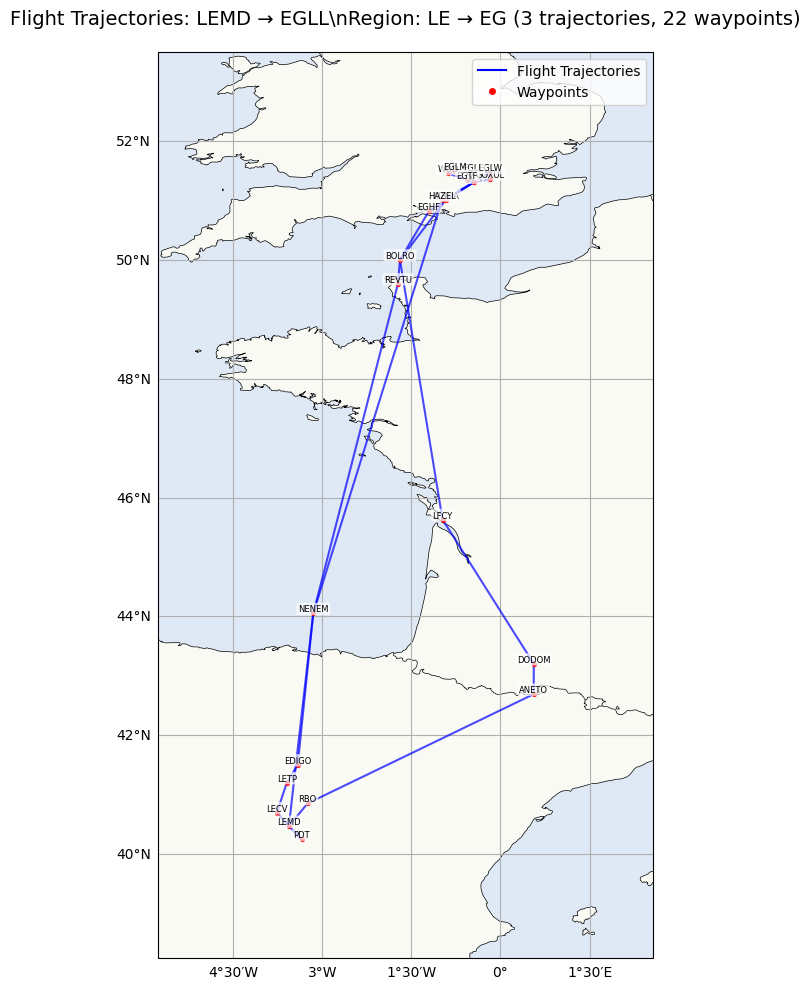

\nVisualization Summary:
- Origin: LEMD (region: LE)
- Destination: EGLL (region: EG)
- CSV file: LEEG_representatives.csv
- Trajectories for this route: 3
- Trajectories plotted: 3
- Unique waypoints: 22
- Waypoint labels: Shown
- Map extent: [-5.763332999999999, 2.5604, 38.252917, 53.500556]


In [8]:
# Example: Visualize trajectories from LFPG to LFBO (Paris to Bordeaux)
# This will automatically find LFLF_representatives.csv
visualize_trajectories('LEMD', 'EGLL', 
                      max_trajectories=30, 
                      show_waypoints=True, 
                      auto_extent=True)

## Interactive Visualization

Choose any CSV file from the representatives directory for visualization.

In [39]:
# List available CSV files and show usage
csv_files = sorted([f.name for f in CSV_DIR.glob('*.csv')])
print(f"Available CSV files ({len(csv_files)} total):")
for i, filename in enumerate(csv_files[:20]):  # Show first 20
    print(f"{i+1:2d}. {filename}")
if len(csv_files) > 20:
    print(f"... and {len(csv_files)-20} more files")

print("\\n" + "="*60)
print("USAGE EXAMPLES:")
print("="*60)
print("\\n1. Using airport codes with waypoint labels (RECOMMENDED):")
print("   visualize_trajectories('LFPG', 'LFBO')  # Paris to Bordeaux with labels")
print("   visualize_trajectories('EGLL', 'EGKK', show_labels=False)  # Without labels")
print("   visualize_trajectories('EDDF', 'EDDM', max_trajectories=10)  # Limit trajectories")

print("\\n2. Using CSV filename directly:")
print("   visualize_by_csv_filename('LFLF_representatives.csv')")

print("\\n3. Label sizing (automatic based on waypoint count):")
print("   ≤20 waypoints: Large labels (size 8)")
print("   21-50 waypoints: Medium labels (size 6)")
print("   51-100 waypoints: Small labels (size 5)")
print("   >100 waypoints: Tiny labels (size 4)")

print("\\n4. Common airport prefixes:")
print("   LF = France, EG = UK, ED = Germany, LB = Bulgaria, etc.")

Available CSV files (1599 total):
 1. BKED_representatives.csv
 2. BKEF_representatives.csv
 3. BKEG_representatives.csv
 4. BKEK_representatives.csv
 5. BKEN_representatives.csv
 6. BKES_representatives.csv
 7. BKLD_representatives.csv
 8. BKLF_representatives.csv
 9. BKLI_representatives.csv
10. BKLO_representatives.csv
11. BKLR_representatives.csv
12. BKLS_representatives.csv
13. BKLT_representatives.csv
14. BKLW_representatives.csv
15. DADA_representatives.csv
16. DADT_representatives.csv
17. DAEB_representatives.csv
18. DAED_representatives.csv
19. DAEG_representatives.csv
20. DAEK_representatives.csv
... and 1579 more files
\n============================================================
USAGE EXAMPLES:
\n1. Using airport codes with waypoint labels (RECOMMENDED):
   visualize_trajectories('LFPG', 'LFBO')  # Paris to Bordeaux with labels
   visualize_trajectories('EGLL', 'EGKK', show_labels=False)  # Without labels
   visualize_trajectories('EDDF', 'EDDM', max_trajectories=10)  # Li

In [40]:
# More examples:
# visualize_trajectories('EGLL', 'EGKK', max_trajectories=20)  # London area
# visualize_trajectories('EDDF', 'EDDM', max_trajectories=25)  # Germany
# visualize_trajectories('LFPG', 'LFML', max_trajectories=15)  # Paris to Marseille

## Batch Visualization

Function to create visualizations for multiple CSV files.

In [41]:
def batch_visualize(csv_filenames, max_trajectories=20):
    """
    Create visualizations for multiple CSV files.
    
    Args:
        csv_filenames: List of CSV filenames to visualize
        max_trajectories: Maximum trajectories per visualization
    """
    for filename in csv_filenames:
        print(f"\n{'='*60}")
        print(f"Visualizing: {filename}")
        print(f"{'='*60}")
        visualize_trajectories(filename, max_trajectories=max_trajectories)

# Example: Visualize first 3 CSV files
# batch_visualize(csv_files[:3], max_trajectories=15)